# Imminent ICU Admission Classifier with Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
import scipy

import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scikitplot.metrics import *

from utils.data_utils import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *

In [2]:
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir/rf'),
 'figdir': PosixPath('../data/workdir/figures'),
 'dataset_csv': PosixPath('../data/modelready_mm.csv'),
 'modeldir': PosixPath('../data/workdir/rf/models'),
 'vectordir': PosixPath('../data/workdir/vectordir'),
 'str_cols_pkl': PosixPath('../data/str_cols.pkl'),
 'structured_threshold': 0.32,
 'unstructured_threshold': 0.334,
 'mm_threshold': 0.326}

## Load Data

In [3]:
str_cols = pickle.load(open(args.str_cols_pkl, 'rb'))
cols = ['hadm_id'] + str_cols + ['note', 'imi_adm_label']

In [4]:
mm_notes_vitals = pd.read_csv(args.dataset_csv, usecols=cols)
mm_notes_vitals = mm_notes_vitals[mm_notes_vitals['imi_adm_label'] != -1].reset_index(drop=True)

notes_common = mm_notes_vitals[['hadm_id', 'note', 'imi_adm_label']].copy().reset_index(drop=True)
vitals_common = mm_notes_vitals[['hadm_id'] + str_cols + ['imi_adm_label']].copy().reset_index(drop=True)

print(vitals_common.shape, notes_common.shape, mm_notes_vitals.shape, vitals_common['hadm_id'].nunique(), notes_common['hadm_id'].nunique(), mm_notes_vitals['hadm_id'].nunique())

(33870, 50) (33870, 3) (33870, 51) 4003 4003 4003


In [5]:
seed = 643
save = True

## Structured Classifier Dev

In [6]:
df = set_group_splits(vitals_common.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:23.0%
Prevalence of positive class in test set:19.9%


In [7]:
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_vitals_train, x_vitals_test = train_df[str_cols].values, test_df[str_cols].values
x_vitals_train.shape, x_vitals_test.shape

((27752, 48), (6118, 48))

In [8]:
clf = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, oob_score=True, class_weight='balanced', n_jobs=-1)

clf.fit(x_vitals_train, y_train)

prob = clf.predict_proba(x_vitals_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

Text(0, 0.5, 'Sensitivity')

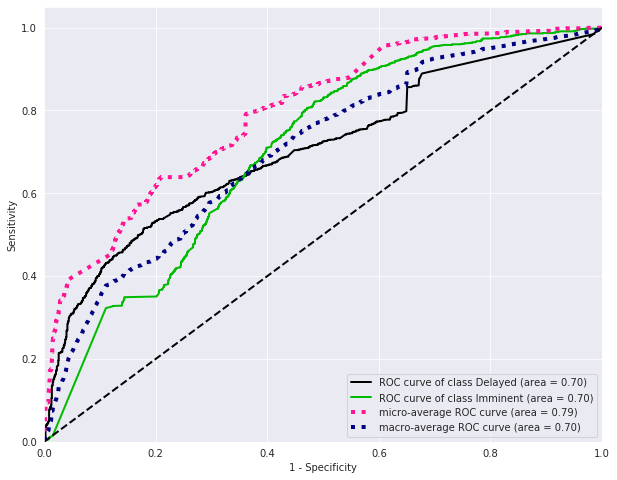

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

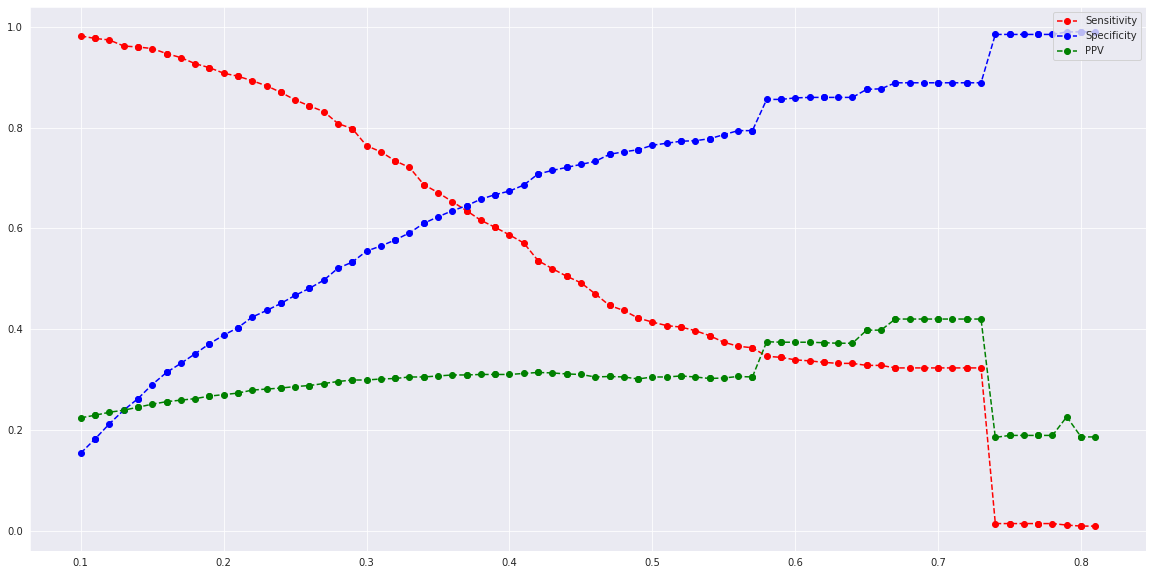

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'rf_structured_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

Best Youden Threshold = 0.29


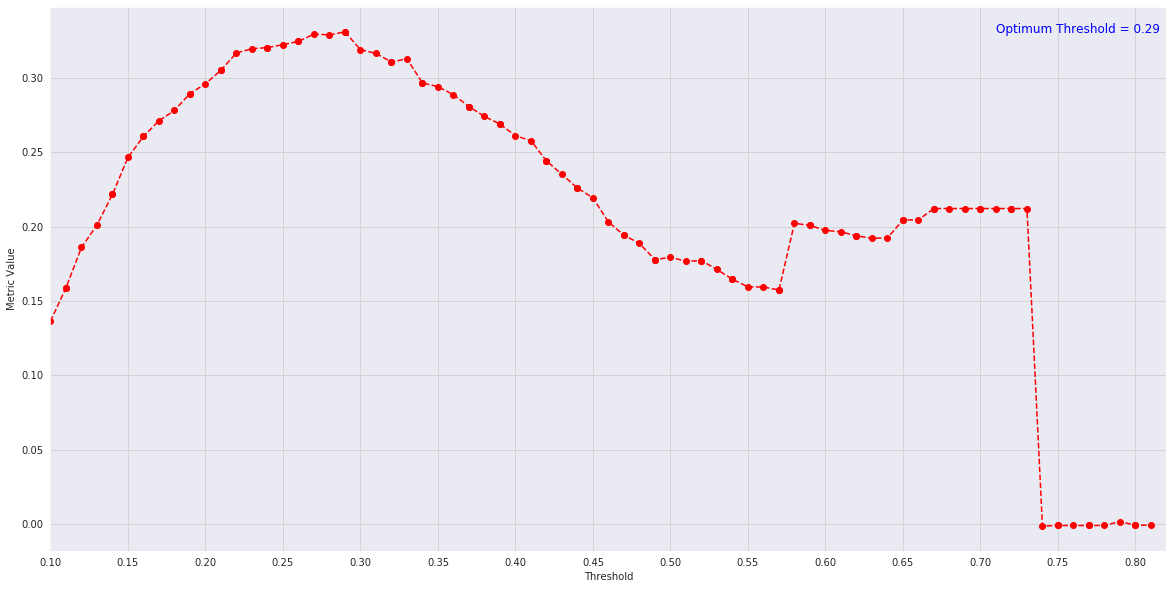

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

if save:
  fig.savefig(args.figdir/f'rf_structured_youden.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [19]:
threshold = 0.33
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.721
specificity,0.591
ppv,0.305
npv,0.895
f1,0.429
auroc,0.705
threshold,0.330


In [ ]:
# fig, ax = plt.subplots(figsize=(11, 8))
# plot_confusion_matrix(label_test, label_preds, x_tick_rotation=45, ax=ax, normalize=False)

## Unstructured Data Classifier Dev

In [20]:
df = set_group_splits(notes_common.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:23.0%
Prevalence of positive class in test set:19.9%


In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
# x_note_train = vectorizer.fit_transform(train_df['note'])
# x_note_test = vectorizer.transform(test_df['note'])

# with open(args.vectordir/f'bigram_643.pkl', 'wb') as f:
#   pickle.dump(vectorizer, f)
#   pickle.dump(x_note_train, f)
#   pickle.dump(x_note_test, f)

In [21]:
with open(args.vectordir/'bigram_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_note_train = pickle.load(f)
  x_note_test = pickle.load(f)
  
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_note_train.shape, x_note_test.shape, y_train.shape, y_test.shape

((27752, 60000), (6118, 60000), (27752,), (6118,))

In [22]:
clf = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, oob_score=True, class_weight='balanced', n_jobs=-1)

clf.fit(x_note_train, y_train)

prob = clf.predict_proba(x_note_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

Text(0, 0.5, 'Sensitivity')

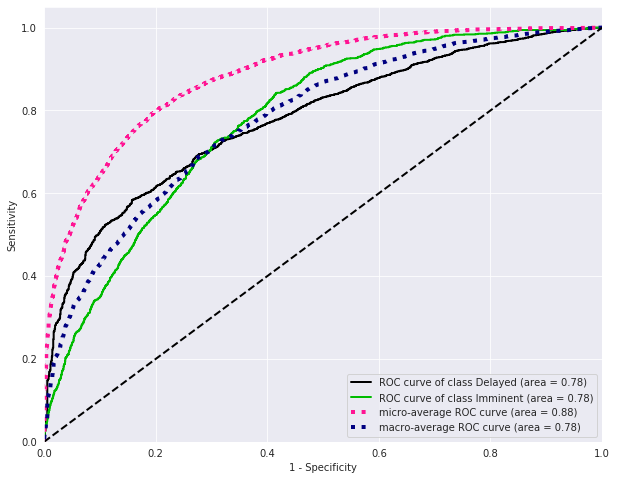

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

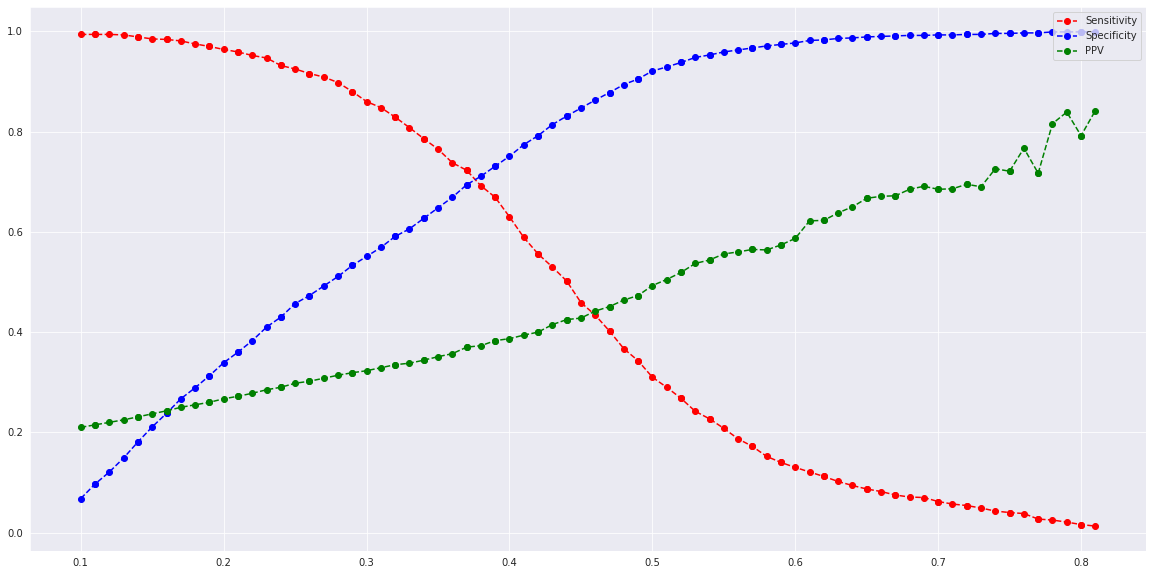

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'rf_unstructured_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

Best Youden Threshold = 0.32


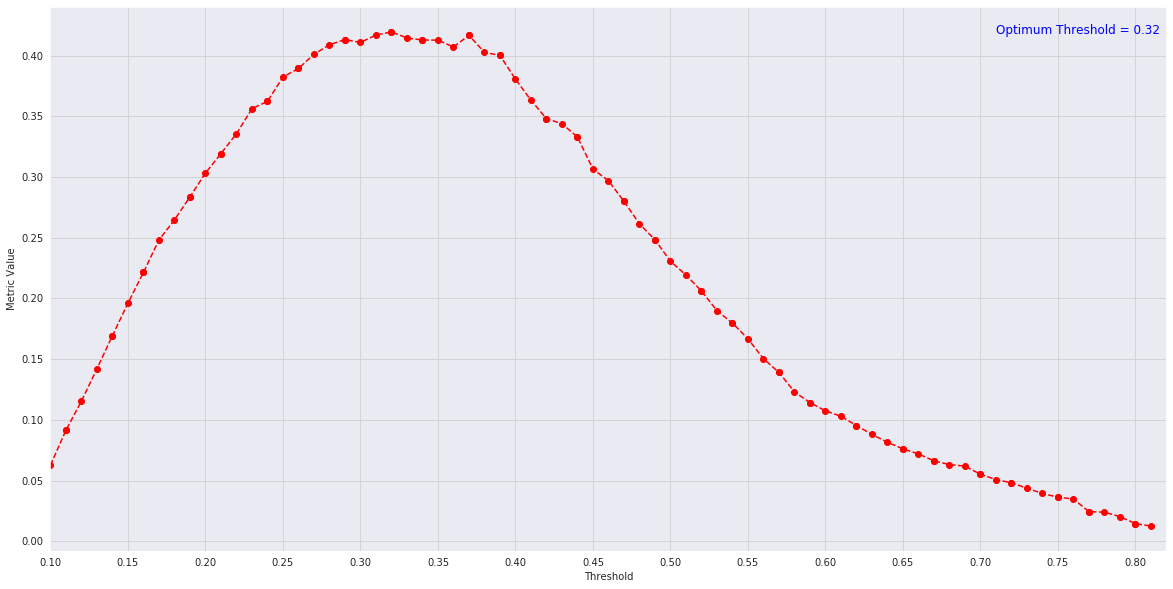

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

if save:
  fig.savefig(args.figdir/f'rf_unstructured_youden.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [26]:
threshold = 0.334
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.800
specificity,0.614
ppv,0.341
npv,0.925
f1,0.478
auroc,0.779
threshold,0.334


## Multimodal Classifier Dev

In [27]:
df = set_group_splits(mm_notes_vitals.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:23.0%
Prevalence of positive class in test set:19.9%


In [28]:
with open(args.vectordir/'bigram_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_note_train = pickle.load(f)
  x_note_test = pickle.load(f)
  
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_note_train.shape, x_note_test.shape, y_train.shape, y_test.shape

((27752, 60000), (6118, 60000), (27752,), (6118,))

In [29]:
x_vitals_train, x_vitals_test = train_df[str_cols].values, test_df[str_cols].values
x_vitals_train.shape, x_vitals_test.shape

((27752, 48), (6118, 48))

In [30]:
x_train = scipy.sparse.hstack((x_vitals_train, x_note_train)).tocsr()
x_test = scipy.sparse.hstack((x_vitals_test, x_note_test)).tocsr()
x_train.shape, x_test.shape

((27752, 60048), (6118, 60048))

In [31]:
clf = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, oob_score=True, class_weight='balanced', n_jobs=-1)

clf.fit(x_train, y_train)

prob = clf.predict_proba(x_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

Text(0, 0.5, 'Sensitivity')

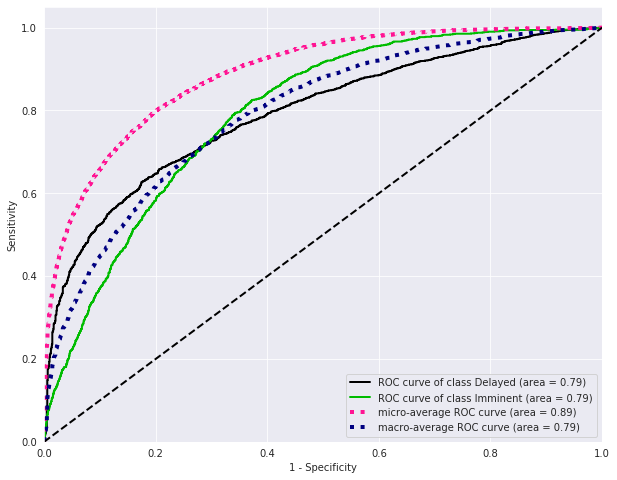

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

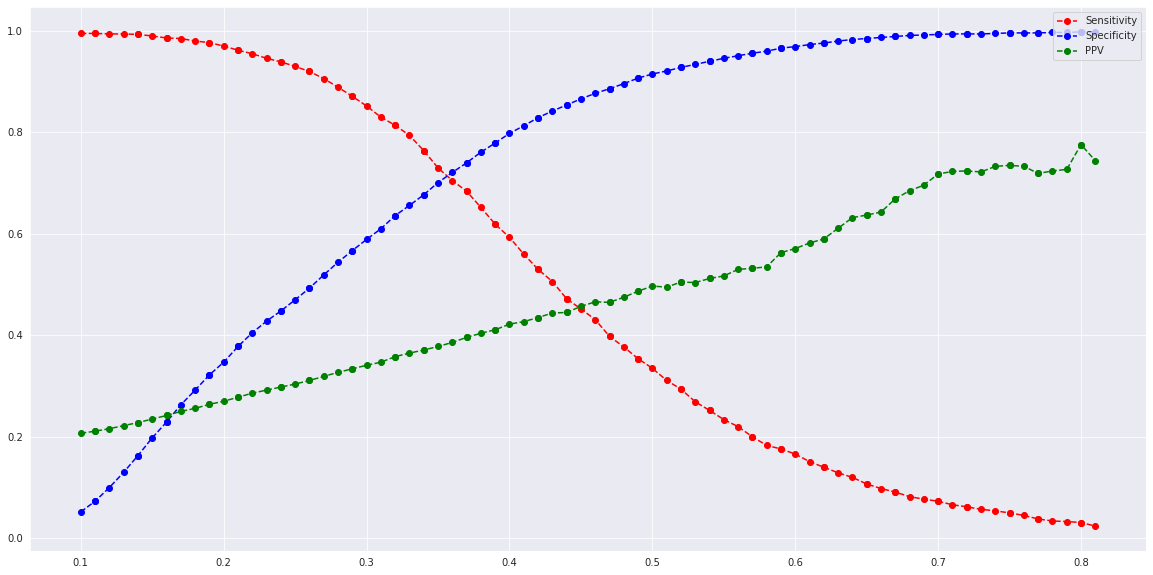

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'rf_mm_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

Best Youden Threshold = 0.33


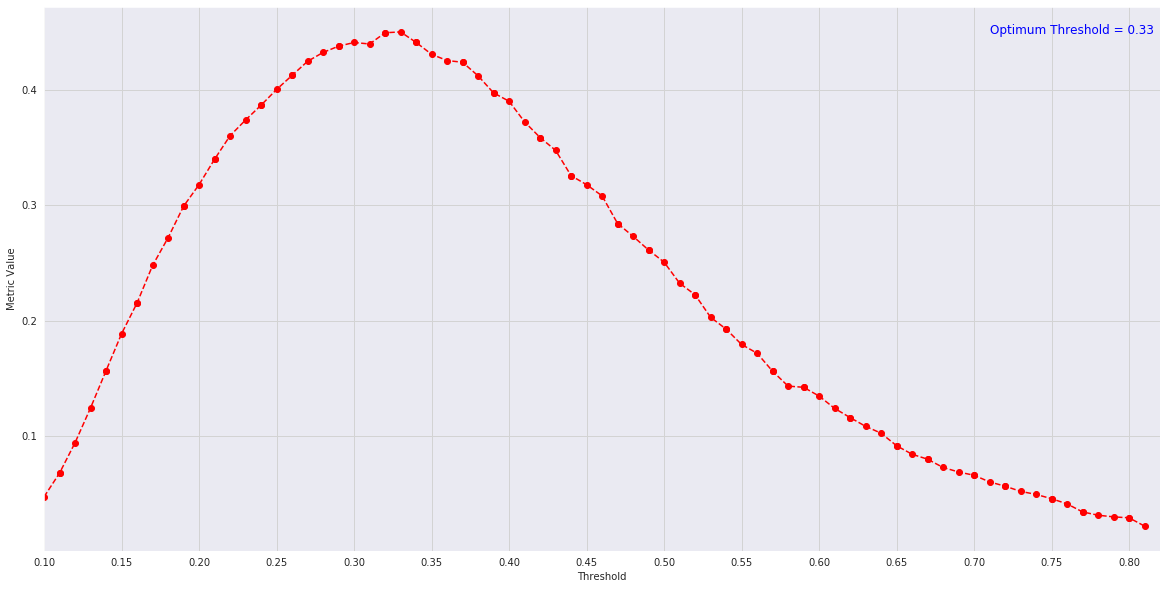

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

if save:
  fig.savefig(args.figdir/f'rf_mm_youden.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [35]:
threshold = 0.326
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.801
specificity,0.647
ppv,0.361
npv,0.929
f1,0.498
auroc,0.792
threshold,0.326


## Metrics

In [36]:
save = False

In [37]:
with open(args.workdir/f's_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.680,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.593,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.350,"When it PREDICTS YES, how often is it correct?"
auroc,0.696,Indicates how well the model is capable of distinguishing between classes
npv,0.851,"When it PREDICTS NO, how often is it correct?"
f1,0.462,Harmonic mean of sensitivity and ppv


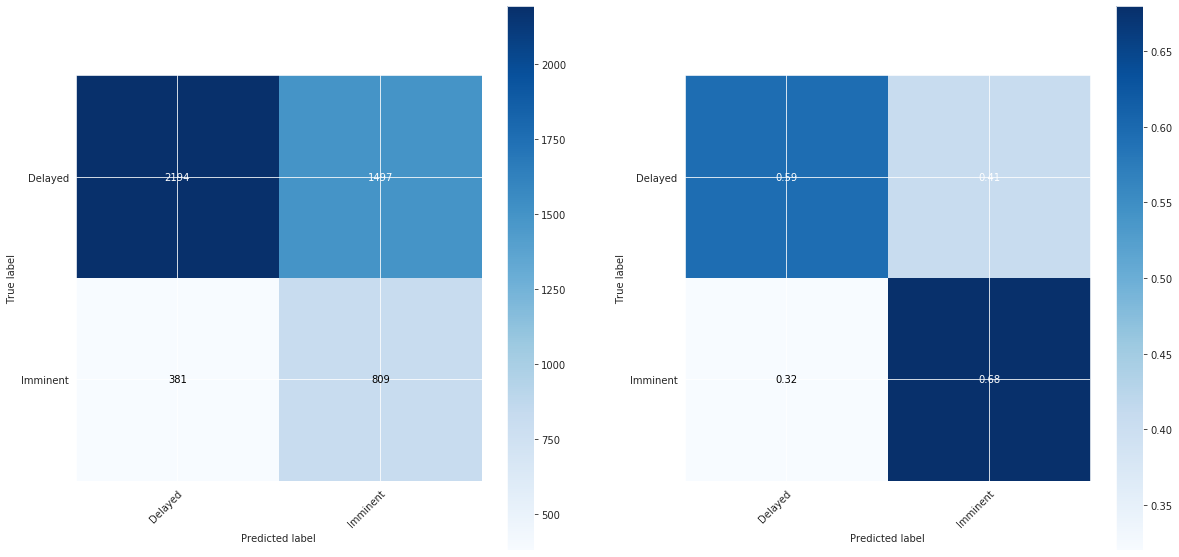

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plot_cm(ax[0], bam.cm_avg, ['Delayed', 'Imminent'], normalize=False)
plot_cm(ax[1], bam.cm_avg, ['Delayed', 'Imminent'], normalize=True)

if save:
  fig.savefig(args.figdir/f'lr_s_mean_cm.pdf', dpi=300, box_inches='tight', pad_inches=0)

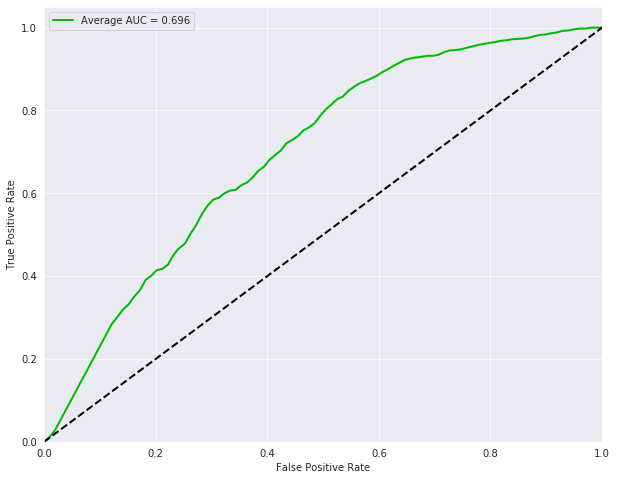

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'lr_s_mean_roc.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [40]:
with open(args.workdir/f'u_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.788,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.592,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.384,"When it PREDICTS YES, how often is it correct?"
auroc,0.755,Indicates how well the model is capable of distinguishing between classes
npv,0.897,"When it PREDICTS NO, how often is it correct?"
f1,0.516,Harmonic mean of sensitivity and ppv


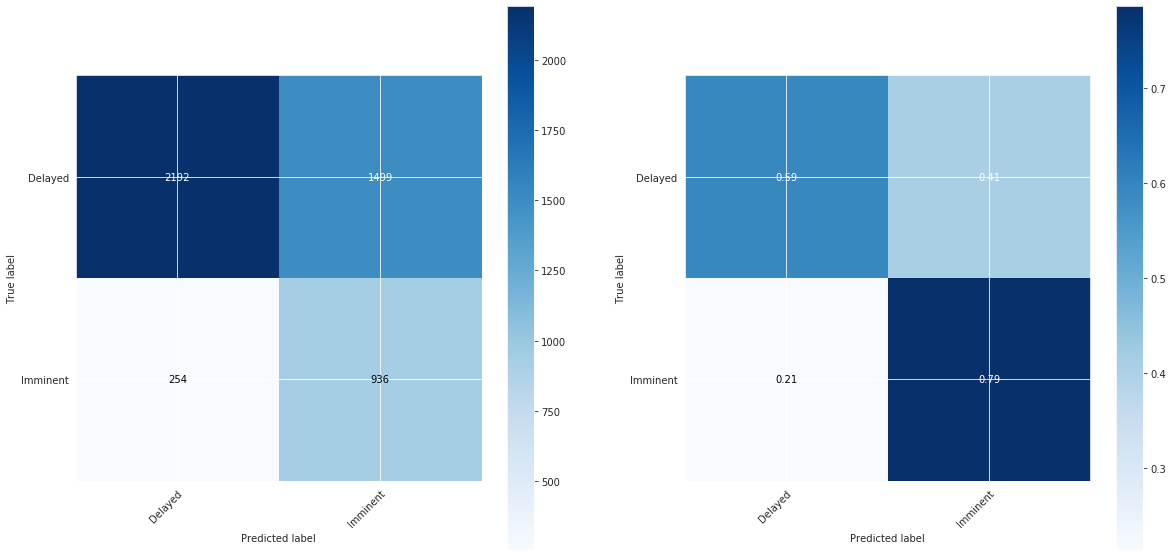

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plot_cm(ax[0], bam.cm_avg, ['Delayed', 'Imminent'], normalize=False)
plot_cm(ax[1], bam.cm_avg, ['Delayed', 'Imminent'], normalize=True)

if save:
  fig.savefig(args.figdir/f'lr_u_mean_cm.pdf', dpi=300, box_inches='tight', pad_inches=0)

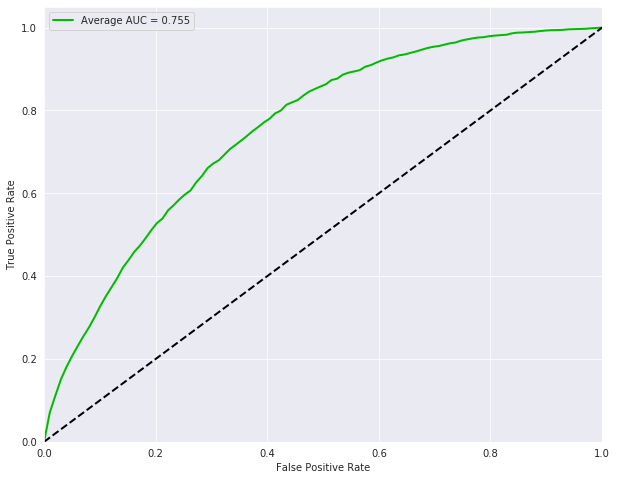

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'lr_u_mean_roc.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [43]:
with open(args.workdir/f'u+s_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.788,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.610,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.395,"When it PREDICTS YES, how often is it correct?"
auroc,0.757,Indicates how well the model is capable of distinguishing between classes
npv,0.899,"When it PREDICTS NO, how often is it correct?"
f1,0.526,Harmonic mean of sensitivity and ppv


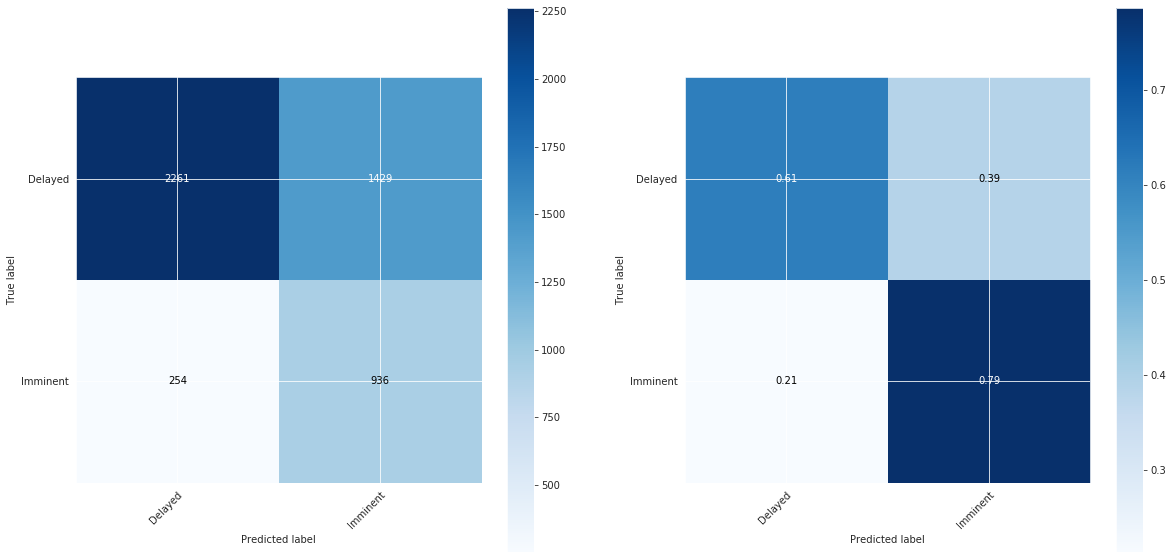

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plot_cm(ax[0], bam.cm_avg, ['Delayed', 'Imminent'], normalize=False)
plot_cm(ax[1], bam.cm_avg, ['Delayed', 'Imminent'], normalize=True)

if save:
  fig.savefig(args.figdir/f'lr_u+s_mean_cm.pdf', dpi=300, box_inches='tight', pad_inches=0)

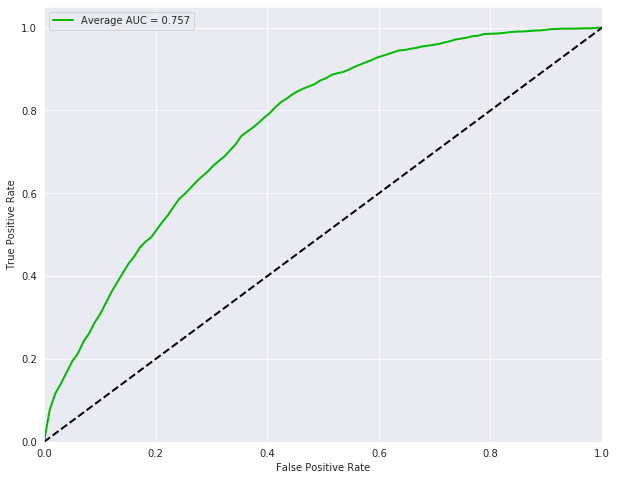

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'lr_u+s_mean_roc.pdf', dpi=300, box_inches='tight', pad_inches=0)